# Assignment 7

**Computer info:** MacBook Air, Chip: Apple M1, Ram: 8GB, macOs 13.4.1, 2020

<div class="alert alert-warning">
<strong>Instructions for Cell Execution:</strong>

1. Execute the cell under "Used Libraries as first".
2. Run the cells in the order they appear.
3. Certain experiments can be computationally expensive and may require a bit of time.
</div>


<div class="alert alert-danger">
    
**Task:** Implement Hamiltonian Monte Carlo (HMC) method in which “momentum” variables are sampled and updated in the usual way (presented in lecture notes and Neal). Use your algorithm to sample from one-dimensional exponential distribution $X\sim  \exp(\lambda)$, where $\lambda = 2$. Use $L = 25$ for the number of leapfrog steps. Try picking the step size of $\varepsilon = 0.1$ (see the note above). You must be sampling only for $x \geq 0$, because $\exp({\lambda})$ is only defined there. (Refer to Lecture 1, p.38, for the exponential distribution.) In order to sample only on the support of $\exp({\lambda})$ you must impose constraints: implement these in your HMC
algorithm.
    
  1. (2 p) First you need to determine $U(q)$
  
  2. (1 p) Second. Write down all functions that you need for your HMC algorithm.
    
  3. (1 p) Third. Write down the constraints for this case. You can do this either by writing lines of pseudo code or by indicating clearly where the constraints are in your HMC algorithm.
    
  4.(3 p) Fourth. Simulate $\exp(2)$ using your HMC. Use $10^6$ samples. Plot the distribution as a histogram using 50 bins together with the pdf of $\exp(2)$ (linear scale/axes are fine).

</div>

### Pseudocode

Pseudo algorithm for a single iteration of HMC in 1d (R.M. Neal, p 14):
    
1. Initiate $q$. $q^*=q_0$.$\leftarrow$. This is done only for the first iteration.

2. Sample $p_0\sim N(0,1)$. $p^*: = p_0$
3. Alternate full steps for position and momentum for ($i := 1, L$):

    Make a half step for momentum
    
    $p^* : =p^* − \frac{\varepsilon}{2} \cdot\frac{dU(q^*)}{dq}$
    
    Make a full step for the position
    
    $q^* := q^*+\varepsilon p^*$
    
    Make a half step for momentum
    
    $p^* ≔ p^*  − \frac{\varepsilon}{2} \cdot\frac{dU(q^*)}{dq}$
    
4. Negate momentum at the end of trajectory $p^* ≔ −p^*$
    
5. Evaluate potential and kinetic energies at start and end of trajectory $U_0=U(q_0)$, $K_0= p_0^2/2$, $U^* = U(q*)$ and $K^*=(p^*)^2/2$.

6. Accept or reject the proposed state
    $q^*=q^*$, if $u<\exp(U_0-U^*+K_0-K^*)$; $q^*=q^0$, if $u\geq \exp(U_0-U^*+K_0-K^*)$.$u\sim U(0,1)$
    
Hint. When deriving $U(q)$ you will find the identity $A \exp(−B) = \exp (\log(A) − B)$ useful.

In [1]:
# Used libraries

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
sns.set(rc={"figure.facecolor":"#FCE6C9"})

np.random.seed(42)

## Point 1

Our objective distribution follows an exponential distribution, $\pi(q) = \lambda e^{-\lambda q}$:

\begin{equation}
\begin{cases}
p_X(x) = \lambda \mathrm{e}^{\lambda x}\\
p_X(x) = \frac{1}{Z}\exp\left(\frac{-E(x)}{kT}\right)\text{.}
\end{cases}
\end{equation}

Here, $T$ represents temperature, and $k$ is the Boltzmann constant, which we set to 1 due to the inconsequence of absolute energy values in our context. This simplifies the expression to:

\begin{equation}
p_X(x) = \frac{1}{Z}\exp\left(\frac{-E(x)}{T}\right)\text{.}
\end{equation}

$Z$ is the partition function, involving a summation over all states in the system, serving as the normalization constant in statistical and stochastic distributions. Typically, this value is incalculable. In our approach, we set $T = 1$, leading to:

\begin{equation}
E(x) = -\log p_X(x) - \log Z\text{.}
\end{equation}

**Hamiltonian and Joint Distribution**

The Hamiltonian $H(p, q) = K(p) + U(q)$ represents the energy function for the combined state of position $q$ and momentum $p$, defining the joint distribution:

\begin{equation}
p_{p,q}(p,q) = \frac{1}{Z}\exp\left(\frac{-U(p)}{T}\right)\exp\left(\frac{-K(p)}{T}\right)\text{.}
\end{equation}

Here, $q$ represents the variables of interest, while $p$ governs the dynamics. The equation $H(p,q) = \text{constant} \Rightarrow p_{p,q} = \text{constant}$ holds when the computation is exact.

**Decomposition of the Hamiltonian and Joint Density (Bentancour)**

The decomposition of the Hamiltonian and the joint density, following Bentancour's notation, can be expressed as:

\begin{equation}
U(p,q) = -\log[\pi(q|p)] - \log[\pi(q)] \equiv K + U\text{.}
\end{equation}

In our specific case, where $\pi(q) = \lambda e^{-\lambda q}$, the energy function simplifies as follows:

\begin{equation}
U(q) = -\log(\lambda e^{-\lambda q}) = -\log(\lambda) - \log\left(e^{-\lambda q}\right) = -\log(\lambda) - \left(-\lambda q\right) = \lambda q - \log\lambda\text{.}
\end{equation}

## Point 2

For the equations needed and used, please refer to the section above.

The first function we need is `potential_energy`, which essentially computes $U(q) = -\log[\pi(q|p)] - \log[\pi(q)]$.

Then, we need to compute the kinetic energy using the function `kinetic_energy`, based on its definition:

$$
K(p) = \frac{1}{2}p^2\text{.}
$$

It is primarily used to determine the acceptance or rejection of a sample \(q^*\) obtained with the leapfrog method.

Another helpful function, aimed at making the code more understandable, is `hamiltonian_func`, based on its definition:

$$
H(p, q) = K(p) + U(q)\text{.}
$$

It is also used in the acceptance step.

We will also use a function for the Leapfrog Method, namely `leapfrog_iterator` (for more details, see point 3 of the pseudocode in the first cell). However, we must be aware of the presence of constraints.

Please note that we don't require a function for the derivative of $U$ since it is constant:

$$
\frac{dU}{dq} = \frac{d}{dq}\left(\lambda q - \log\lambda\right) = \lambda\text{.}
$$

Another valuable function is `accept`, for which you can refer to the last point of the pseudocode in the first cell.

In the code provided below, you will find these functions, except for `leapfrog`, which will be described in the next point.

In [2]:
def potential_energy(q,lam=2.0):
    return lam * q - np.log(lam)

def kinetic_energy(p,lam=2.0):
    return p**2 / 2

def hamiltonian_func(p, q,lam=2.0):
    return kinetic_energy(p,lam=lam) + potential_energy(q,lam=lam)

def accept(p,q,p_0,q_0,lam=2):
    
    E_0= hamiltonian_func(p_0,q_0,lam=lam)
    E=hamiltonian_func(p,q,lam=lam)

    u = np.random.uniform(0, 1)
    if u >= np.exp(E_0 - E):
        q = q_0
    
    return q

## Point 3

In the Hamiltonian Monte Carlo (HMC) algorithm for sampling from the one-dimensional exponential distribution $\exp(\lambda)$, we need to impose constraints to ensure that the samples are generated only for valid values of `q` (i.e., `q >= 0`). Here's how these constraints are applied within the algorithm:

### Implementing constraints

1. $p'=p(t+\varepsilon/2)$.

2. $q'=q(t)+q(t)+\varepsilon p'$.

3. Since $q$ has an upper bound $l=0$, repeat the following until:satisfies all constraints: $ q'=-q'$ and $p'=-p'$.
       
4. Let $q(t+\varepsilon)=q'$ and $p(t+\varepsilon/2)=p'$.

In [3]:
def leapfrog(p, q, epsilon=0.1, L=25,lam=2.0):
    for _ in range(L):
        p = p - epsilon/2 * lam
        q = q + epsilon * p
        if q < 0:
            q = -q
            p = -p
        p = p - epsilon/2 * lam
    return q, p

## Point 4

Below you can find the function that combines all previous functions in oderd to simulate.

In [4]:
def hmc_sampling(q_start, epsilon=0.1, L=25, num_samples=10**6,lam=2.0):
    q_0 = q_start
    q = q_0
    samples = []

    for i in range(num_samples):
        p_0 = np.random.normal(0, 1)
        p = p_0
        q, p = leapfrog(p, q, epsilon, L,lam=lam)
        p = -p

        q=accept(p,q,p_0,q_0)

        samples.append(q)

    return samples

In [9]:
lam = 2.0  # Lambda for the exponential distribution
epsilon = 0.1  # Step size
num_leapfrog_steps = 25
num_samples = 1000000

samples = hmc_sampling(3)

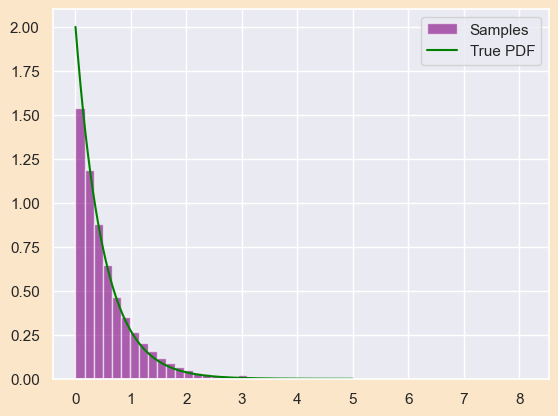

In [10]:
# Plot the samples as a histogram
plt.hist(samples, bins=50, density=True, alpha=0.6, color='purple', label='Samples')
    
# Plot the true exponential distribution (PDF)
x = np.linspace(0, 5, 1000)
true_pdf = lam * np.exp(-lam * x)
plt.plot(x, true_pdf, 'green', label='True PDF')

plt.grid(True)
plt.legend()
plt.show()